In [2]:
import os
import ogr
import gdal
import zipfile
#import rasterio 
import numpy as np
import pandas as pd
from tqdm import tqdm
from uuid import uuid4
import geopandas as gpd
from datetime import date
from sentinelsat import SentinelAPI
from shapely.geometry import Polygon
from shapely.wkt import loads
from matplotlib import pyplot as plt

# Project Settings

In [3]:
settings = {}
settings['projectdir'] = r'C:\Users\csoti\Desktop\notebooks\Github\GMV'
settings['input'] = os.path.join(settings['projectdir'], 'input')
settings['raw_images'] = os.path.join(settings['projectdir'], 'raw_images')
settings['proc_images'] = os.path.join(settings['projectdir'], 'proc_images')
settings['stack_images'] = os.path.join(settings['projectdir'], 'stack_images')
settings['ndvi'] = os.path.join(settings['projectdir'], 'ndvi')

# Download & Atmospheric Correction of Sentinel-2 L1C TOA to L2A BOA

### Settings

In [4]:
# SENTINEL 2 SETTINGS
# Login to the server with your username and password
api = SentinelAPI('christiansot', 'belit61218', 'https://scihub.copernicus.eu/dhus')
# Area of interest, written as WKT string
aoi = 'POLYGON((21.335243298645867 37.676444083936545,21.40635380468978 37.676444083936545,21.40635380468978 37.72013266892898,21.335243298645867 37.72013266892898,21.335243298645867 37.676444083936545))'
# Product type
producttype= 'S2MSI1C'
# Time period
date=("20230704","20230708")
# download folder of raw data
rawdir = settings['raw_images']
# Sen2cor path in Windows folder
Sen2corPath = r'C:\Users\csoti\AppData\Local\Sen2Cor-02.11.00-win64\L2A_Process.bat'

### Functions

In [5]:
def download_S2(api, aoi, date, producttype, rawdir):
    download_candidate = api.query(area=aoi, date=date ,producttype= producttype) 
    title_found_sum = 0
    for key, value in download_candidate.items():
        for k, v in value.items():
            if k == 'title':
                title_info = v
                title_found_sum += 1
            elif k == 'size':
                print("title: " + title_info + " | " + v)
    print("Total found " + str(title_found_sum) +
          " title of " + str(api.get_products_size(download_candidate)) + " GB")

    os.chdir(rawdir)
    if (rawdir + "*.zip") not in [value for value in download_candidate.items()]:
        api.download_all(download_candidate)
        print("Finish Downloading")
    else:
        print("Escaping download")

def un_zipFiles(path):
    files=os.listdir(path)
    for file in tqdm(files):
        if file.endswith('.zip'):
            print(file)
            filePath=path+'/'+file
            zip_file = zipfile.ZipFile(filePath)
            for names in zip_file.namelist():
                zip_file.extract(names,path)
            zip_file.close()   
            
def L2A_Process(path, Sen2corPath):
    for raw_file in os.listdir(path):
        if raw_file.endswith('.SAFE'):
            RawfilePath = os.path.join(path, raw_file)
            cmd = Sen2corPath +  ' --resolution=10 ' + RawfilePath
            print(cmd)
            os.system(cmd)

### Run

In [63]:
download_S2(api, aoi, date, producttype, rawdir)

title: S2A_MSIL1C_20230707T092031_N0509_R093_T34SEG_20230707T112153 | 799.06 MB
Total found 1 title of 0.78 GB


Downloading: 100%|██████████████████████████████████████████████████████████████████| 838M/838M [01:46<00:00, 7.84MB/s]
MD5 checksumming: 100%|█████████████████████████████████████████████████████████████| 838M/838M [00:11<00:00, 73.2MB/s]

Finish Downloading


In [64]:
un_zipFiles(rawdir)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

S2A_MSIL1C_20230707T092031_N0509_R093_T34SEG_20230707T112153.zip


 50%|██████████████████████████████████████████                                          | 1/2 [00:17<00:17, 17.57s/it]

S2B_MSIL1C_20230702T091559_N0509_R093_T34SEG_20230702T095527.zip


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:30<00:00, 15.01s/it]


In [ ]:
L2A_Process(rawdir, Sen2corPath)

C:\Users\csoti\AppData\Local\Sen2Cor-02.11.00-win64\L2A_Process.bat --resolution=10 C:\Users\csoti\Desktop\notebooks\Github\GMV\raw_images\S2A_MSIL1C_20230707T092031_N0509_R093_T34SEG_20230707T112153.SAFE
C:\Users\csoti\AppData\Local\Sen2Cor-02.11.00-win64\L2A_Process.bat --resolution=10 C:\Users\csoti\Desktop\notebooks\Github\GMV\raw_images\S2B_MSIL1C_20230702T091559_N0509_R093_T34SEG_20230702T095527.SAFE


# Convert & Stack L2A bands

### Settings

In [6]:
procdir = settings['proc_images']
stackdir = settings['stack_images']

### Functions

In [7]:
def find(rootdir, endswith):
    """
    Find selected data from a rootdir that end with: ex. '.tif'
    """    
    finder = []
    for root, dirs, files in os.walk(rootdir):
        for f in files:
            if f.endswith(endswith):
                fullpath = os.path.join(root, f)
                finder.append(fullpath)
    return finder

### Convert

In [7]:
from glob import glob

for l2adir in glob(rawdir + '/*/', recursive = True):
    if l2adir.split('_')[2] == 'MSIL2A':
        date = str(l2adir.split('_')[3][:8])

        b4proc = find(l2adir, 'B04_10m.jp2')[0]
        src_04 = gdal.Open(b4proc)
        out_04 = os.path.join(procdir, date + '_B04.tif')
        if not os.path.exists(out_04):
            b4convert = gdal.Translate(out_04, src_04)
        
        b8proc = find(l2adir, 'B08_10m.jp2')[0]
        src_08 = gdal.Open(b8proc)
        out_08 = os.path.join(procdir, date + '_B08.tif')
        if not os.path.exists(out_08):
            b8convert = gdal.Translate(out_08, src_08)



### Stack

In [11]:
from osgeo import gdal
outvrt = os.path.join(stackdir, date + '_L2A_stack.vrt') #/vsimem is special in-memory virtual "directory"
outtif = os.path.join(stackdir, date + '_L2A_stack.tif')
tifs = [b4convert, b8convert] 

outds = gdal.BuildVRT(outvrt, tifs, separate=True)
outds = gdal.Translate(outtif, outds)

# Subset stack with shapefile

### Settings

In [12]:
inputdir = settings['input']
shp = os.path.join(inputdir,'test_area.shp')

### Functions

In [13]:
def get_coords_from_shp(shp):
    ds = ogr.Open(shp)
    lyr = ds.GetLayer()
    ft = lyr.GetFeature(0)
    geom = ft.GetGeometryRef()
    coords_shp = geom.GetEnvelope()
    geom = None
    ft = None
    lyr = None
    ds = None
    return coords_shp              

def reprj_shp(shp, EPSG):
    """
    Reproject shapefile to ESPG. Requires shapefile path and EPSG as ''EPSG:32634''
    """  
    outdir = os.path.dirname(shp) #  reprojects to the same folder where input shapefile is
    input_shp = gpd.read_file(shp)
    # change CRS 
    output_shp = input_shp.to_crs(EPSG)
    # write shp file
    epsg = '_' + 'epsg' + EPSG.split(':')[1]
    reprj_shp_name = os.path.basename(shp).replace('.shp', epsg + '.shp')
    reprj_shp_path = os.path.join(outdir,reprj_shp_name)
    if not os.path.exists(reprj_shp_path):
        reprj_shp = output_shp.to_file(reprj_shp_path)
    return reprj_shp_path

### Run

In [14]:
shp_new = reprj_shp(shp, 'EPSG:32634')
shp_new

'C:\\Users\\csoti\\Desktop\\notebooks\\Github\\GMV\\input\\test_area_epsg32634.shp'

In [15]:
coords_shp = get_coords_from_shp(shp_new)
extent = [coords_shp[0],coords_shp[2],coords_shp[1],coords_shp[3]]
extent

[528349.4746660291, 4169879.364360689, 537529.433635496, 4174733.961879773]

In [16]:
outtif_subset = os.path.join(stackdir,'20200831_L2Astack_subset.tif')

options = gdal.WarpOptions(cutlineDSName=shp,outputBounds= extent, dstNodata=-1)
outBand = gdal.Warp(srcDSOrSrcDSTab=outtif,
                    destNameOrDestDS=outtif_subset,
                    options=options)

### Plot

(485, 918)


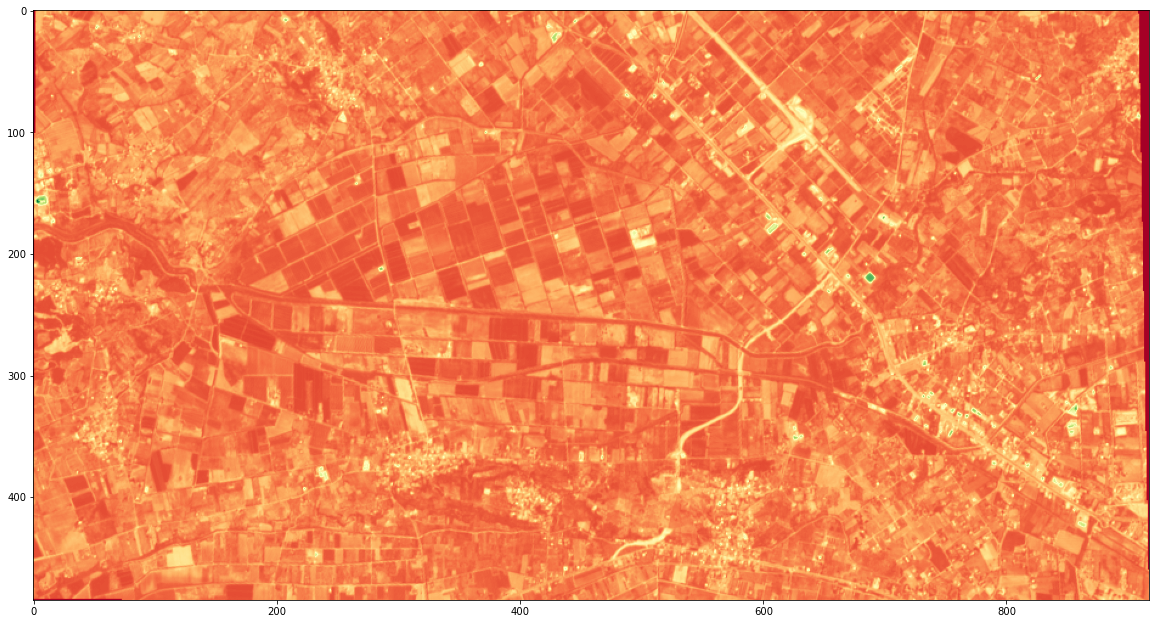

In [17]:
%matplotlib inline  
dataset = gdal.Open(outtif_subset)
band = dataset.GetRasterBand(1)
img = band.ReadAsArray()

import matplotlib.pyplot as plt
print (img.shape)

plt.figure(figsize=(20,20))
plt.imshow(img, cmap="RdYlGn")

plt.show()

# Calculate NDVI from L2A

### Settings 

In [18]:
# ndvi output file
ndvidir = settings['ndvi']
ndvi_out = os.path.join(ndvidir, date + '_L2A_ndvi.tif')

### Functions

In [21]:
def calculate_ndvi_from_L2A(L2A_image):
    
    L2A_img = gdal.Open(L2A_image)

    d8 = L2A_img.GetRasterBand(2)
    d4 = L2A_img.GetRasterBand(1)

    nir = d8.ReadAsArray()
    print(nir.max(),nir.min())
    nir = nir/10000
    nir = nir/2.045
    red = d4.ReadAsArray()
    print(red.max(),red.min())
    red = red/10000
    red = red/2.045

    # Ndvi calculation 
    ndvi = (nir - red) / (nir + red)

    print(nir.max(),nir.min())
    print(red.max(),red.min())
    
    return ndvi

def ndvi2tif(L2A_band, ndvi_in, ndvi_out):
    with rasterio.open(L2A_band) as src:
        profile = src.profile.copy()
        profile.update({
                'dtype': 'float64',
                'height': ndvi_in.shape[0],
                'width': ndvi_in.shape[1]})  

        with rasterio.open(ndvi_out, 'w', **profile) as dst:
            dst.write_band(1, ndvi_in)

### Run

In [22]:
ndvi = calculate_ndvi_from_L2A(outtif_subset)

8100 0
8544 0
0.39608801955990225 0.0
0.417799511002445 0.0


C:\Users\csoti\Miniconda3\envs\gmv\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


### Plot NDVI

(485, 918)


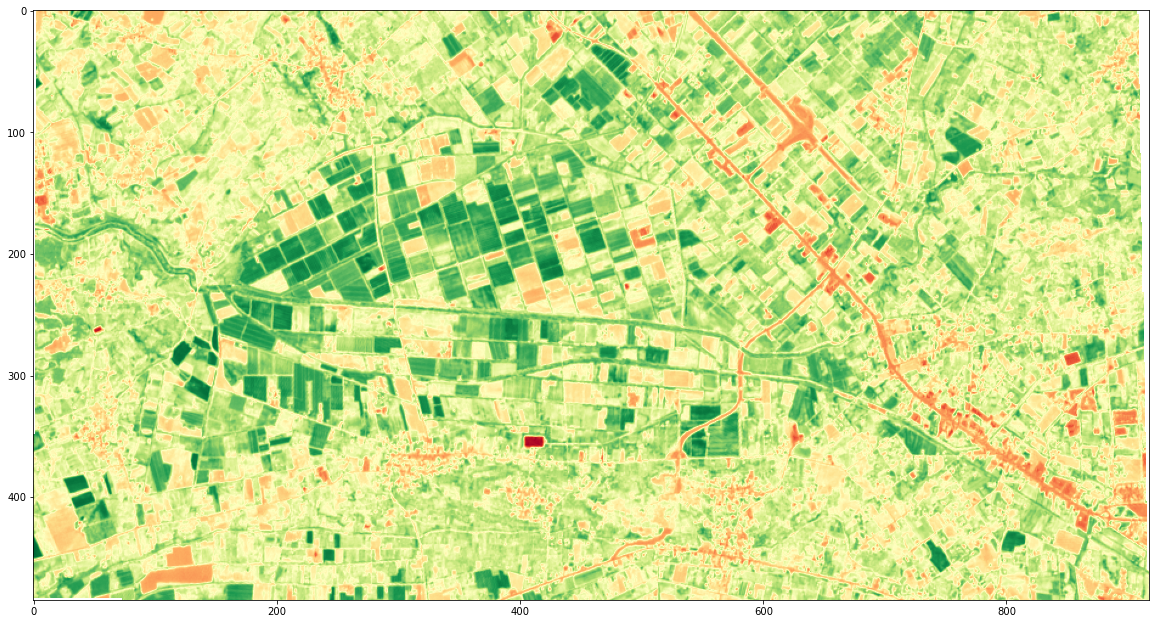

In [23]:
%matplotlib inline  
print (ndvi.shape)

plt.figure(figsize=(20,20))
plt.imshow(ndvi, cmap="RdYlGn")

plt.show()

### Save to tif

In [29]:
ndvi2tif(b8cnv, ndvi, ndvi_out)

### reproject

In [25]:
filename = ndvi_out
input_ndvi = gdal.Open(filename)
final_ndvi = os.path.join(ndvidir, date + '_L2A_ndvi_4326.tif')
gdal.Warp(final_ndvi,input_ndvi,dstSRS='EPSG:4326')

SystemError: <built-in function wrapper_GDALWarpDestName> returned NULL without setting an error

# Clustering on NDVI

In [10]:
from sklearn import cluster
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Settings

In [11]:
ndvi_aoi = r'C:\Users\csoti\Desktop\notebooks\GeoScripting\inputs\20200831_ndvi_subset_final.tif'

### Run

In [37]:
dataset = gdal.Open(ndvi_aoi)
band = dataset.GetRasterBand(1)
img = band.ReadAsArray()

X = img.reshape((-1, 1)) # reshaping from  2D dimensions 
k_means = cluster.KMeans(n_clusters=4) # create an object of the classifier
param = k_means.fit(X) # train it
img_cl  = k_means.labels_ # get labels of the classes
img_cl  = img_cl.reshape(img.shape) # reshape labels 

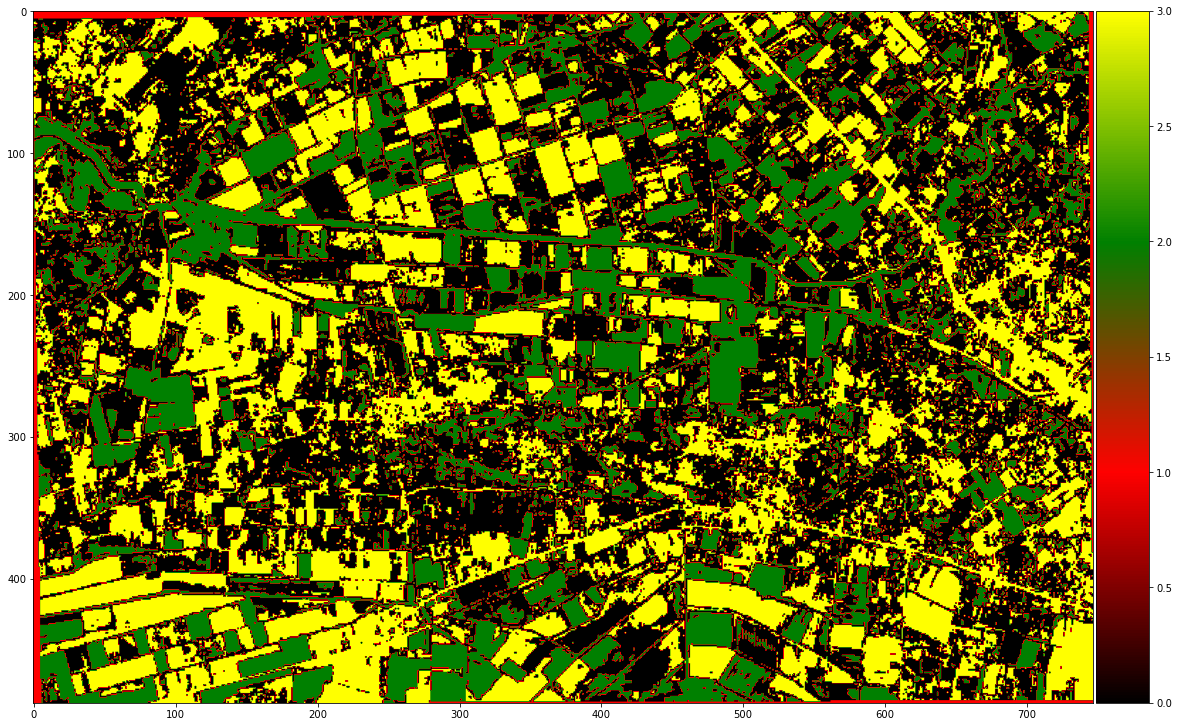

In [38]:
# Create a custom color map to represent the 4 classes
cmap = clr.LinearSegmentedColormap.from_list("", ["black","red","green","yellow"])# Show the resulting array and save it as jpg image
plt.figure(figsize=[20,20])
ax = plt.gca()
im = ax.imshow(img_cl, cmap=cmap)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)